# Autoencoders

## 1. The data

In this notebook, we will train an auto-encoder to work on 28x28 grey images from the MNIST dataset, available in keras. Run the cells below

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print(images_train.shape)
print(images_test.shape)

2021-12-05 16:29:58.595486: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


(60000, 28, 28)
(10000, 28, 28)


In [2]:
# Add a channels for the colors and normalize data
X_train = images_train.reshape((60000, 28, 28, 1)) / 255.
y_train = to_categorical(labels_train)
X_test = images_test.reshape((10000, 28, 28, 1)) / 255.
y_test = to_categorical(labels_test)

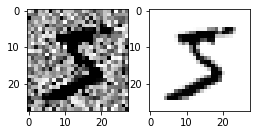

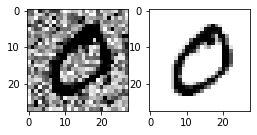

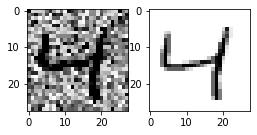

In [3]:
# Put some Noise and Plot some images
import numpy as np

mean = 0.5
sigma=0.25
X_train_noisy = X_train + np.random.normal(mean, sigma, size=X_train.shape)
X_train_noisy[X_train_noisy>1]=1
X_train_noisy[X_train_noisy<0]=0

X_test_noisy = X_test + np.random.normal(mean,sigma, size=X_test.shape)
X_test_noisy[X_test_noisy>1]=1
X_test_noisy[X_test_noisy<0]=0

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(X_train_noisy[i].reshape(28,28), cmap='Greys')
    ax2.imshow(X_train[i].reshape(28,28), cmap='Greys')
    plt.show()

## 2. The Model

### Build

In [5]:
from model_utils import build_autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Encoder (Sequential)            (None, 16)           4712        Input[0][0]                      
__________________________________________________________________________________________________
Classification (Dense)          (None, 10)           170         Encoder[0][0]                    
__________________________________________________________________________________________________
Decoder (Sequential)            (None, 28, 28, 1)    6961        Encoder[0][0]                    
Total params: 11,843
Trainable params: 11,843
Non-trainable params: 0
________________________

2021-12-05 16:05:05.808172: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-05 16:05:05.857037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 16:05:05.857203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.867GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2021-12-05 16:05:05.857218: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-05 16:05:05.885791: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-05 16:05:05.885826: I tensorflow/stream_executor/pl

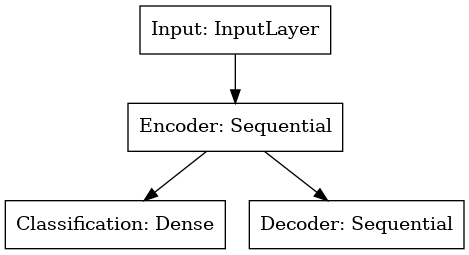

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder)

### Compile

In [7]:
def compile_autoencoder(autoencoder):
    #2 Different losses for each output path + 1 metric for Classif
    # We use layer Names to identify each output
    autoencoder.compile(loss={'Classification':'categorical_crossentropy',
                          'Decoder':'mse'}, 
                  optimizer='adam',
                  metrics = {'Classification':'accuracy'})

compile_autoencoder(autoencoder)

### Train

In [34]:
autoencoder.fit(x=X_train_noisy, 
                y = {"Classification" :y_train,'Decoder': X_train}, 
                epochs=20, 
                batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2813 - Classification_loss: 0.2372 - Decoder_loss: 0.0441 - Classification_accuracy: 0.9250
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2359 - Classification_loss: 0.1935 - Decoder_loss: 0.0424 - Classification_accuracy: 0.9392
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2091 - Classification_loss: 0.1680 - Decoder_loss: 0.0411 - Classification_accuracy: 0.9472
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1906 - Classification_loss: 0.1504 - Decoder_loss: 0.0402 - Classification_accuracy: 0.9529
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1772 - Classification_loss: 0.1377 - Decoder_loss: 0.0395 - Classification_accuracy: 0.9568
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1661 - Classification_loss: 0.1272 - Decoder_loss: 0.0389 - Classificati

# 3. Prediction on Test Set

In [35]:
evaluate = autoencoder.evaluate(X_test_noisy,[y_test,X_test],verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.1386 - Classification_loss: 0.1023 - Decoder_loss: 0.0362 - Classification_accuracy: 0.9700


In [36]:
classif , denoized = autoencoder.predict(X_test_noisy, verbose=0, batch_size=100)# you can now display an image to see it is reconstructed well



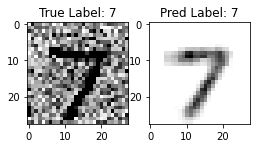

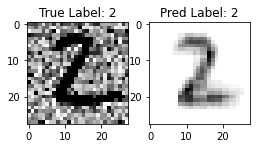

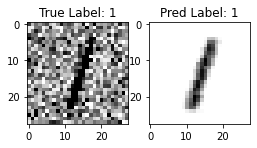

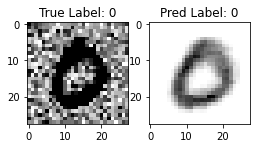

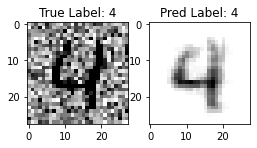

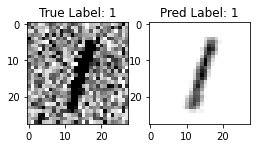

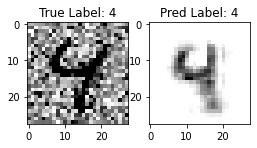

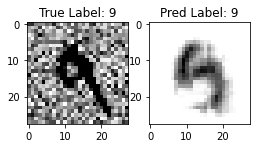

In [37]:
for i in range(8):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(X_test_noisy[i].reshape(28,28), cmap='Greys')
    ax1.set_title(f"True Label: {labels_test[i]}")
    ax2.imshow(denoized[i].reshape(28,28), cmap='Greys')
    ax2.set_title(f"Pred Label: {np.argmax(classif[i])}")
    plt.show()

## Save samples/model for streamlit

In [5]:
from PIL import Image

for i in range(3):
    X_sample_rescale = (X_test_noisy[i]*255).astype('uint8')

    img_sample = Image.fromarray(X_sample_rescale.reshape(28,28)).convert("L") #convert to 1channel image
    img_sample.save(f"sample_test_label-{labels_test[i]}.png")

### Save Only Models

When we know the model's architecture, it takes less memory space to save model's weight especially for heavy models (Streamlit Memory usage is capped to 1Gb RAM)

To load the model in the Streamlit, We have to build the model first and then load the weights

In [ ]:
autoencoder.save_weights("autoencoder_weights.h5")

## Test Streamlit Model

In [59]:
from model_utils import build_autoencoder

In [60]:
model = build_autoencoder()

In [61]:
model.load_weights('autoencoder_weights.h5')

In [62]:
from PIL import Image

In [63]:
img_test = np.array(Image.open('sample_test_label-7.png'))
img_test.shape

(28, 28)

In [64]:
img_test = img_test.reshape(28,28,1)

In [65]:
classif, res_img = model.predict(np.expand_dims(img_test/255.,axis=0))

In [66]:
np.argmax(classif)

7

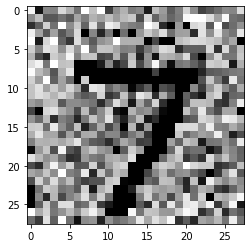

In [67]:
plt.imshow(np.expand_dims(img_test/255.,axis=0)[0],cmap='Greys')